In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks

d:\Learning\University\UIT\AI\Projects\AI4Finance\AI-Project\src


In [2]:
import warnings
warnings.filterwarnings("ignore")

# Part 1. Install necessary independences

In [3]:
# !pip install wrds
# !pip install swig
# !pip install PyPortfolioOpt
# !pip install pyfolio-reloaded
# !pip install -q condacolab
# !pip install stockstats
# !pip install gym
# !pip install gymnasium
# !pip install stable_baselines3
# import condacolab
# condacolab.install()
# !apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig

In [4]:
import sys
import os
import itertools
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime
from plot import backtest_plot, get_baseline, backtest_stats
%matplotlib inline
from preprocessor.preprocessors import FeatureEngineer, data_split
from env.env_stocktrading import StockTradingEnv
from preprocessor.yahoodownloader import YahooDownloader
from models.models import DRLAgent,DRLEnsembleAgent
from stable_baselines3.common.logger import configure
from stable_baselines3 import A2C, DDPG, PPO

from pprint import pprint

import itertools

In [5]:
from config.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
    check_and_make_directories
)
from config.config_tickers import DOW_30_TICKER

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

# Part 2. Load in Data & Trained Models

In [6]:
processed_data = pd.read_csv(DATA_SAVE_DIR + 'processed_full.csv')
processed_data = processed_data.set_index(processed_data.columns[0])
processed_data.index.names = ['']

train = data_split(processed_data, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_data, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

14587
14529


In [7]:
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_ensemble = True

In [8]:
trained_a2c = A2C.load(TRAINED_MODEL_DIR + "agent_a2c") if if_using_a2c else None
trained_ddpg = DDPG.load(TRAINED_MODEL_DIR + "agent_ddpg") if if_using_ddpg else None
trained_ppo = PPO.load(TRAINED_MODEL_DIR + "agent_ppo") if if_using_ppo else None

# Part 3. Backtesting (Out-of-sample Performance)

Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [9]:
INDICATORS = ['macd',
            'rsi_30',
            'cci_30',
            'dx_30']
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 175


In [10]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

e_trade = StockTradingEnv(df = train, **env_kwargs)

In [11]:
e_test_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [12]:
train_model = trained_a2c
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=train_model,
    environment = e_test_gym) if if_using_a2c else None

Episode: 2
hit end!


In [13]:
train_model = trained_ppo
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=train_model,
    environment = e_test_gym) if if_using_ppo else None

Episode: 5
hit end!


In [14]:
train_model = trained_ddpg
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=train_model,
    environment = e_test_gym) if if_using_ddpg else None

Episode: 8
hit end!


==============Compare to DJIA===========
-----------DOWNLOADING-----------
From = 2022-01-01 to 2024-01-01.


[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (501, 8)


Start date,2022-01-03
End date,2023-12-29
Total months,23
,Backtest
Annual return,6.276%
Cumulative returns,12.863%
Annual volatility,18.014%
Sharpe ratio,0.43
Calmar ratio,0.28
Stability,0.42
Max drawdown,-22.814%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,22.81,2022-01-03,2022-09-30,2023-04-13,334
1,11.63,2023-07-31,2023-10-27,2023-11-30,89
2,2.96,2023-04-13,2023-05-25,2023-06-02,37
3,2.39,2023-06-15,2023-06-26,2023-07-11,19
4,1.27,2023-06-02,2023-06-06,2023-06-08,5


Stress Events,mean,min,max
Covid,0.03%,-4.27%,3.14%


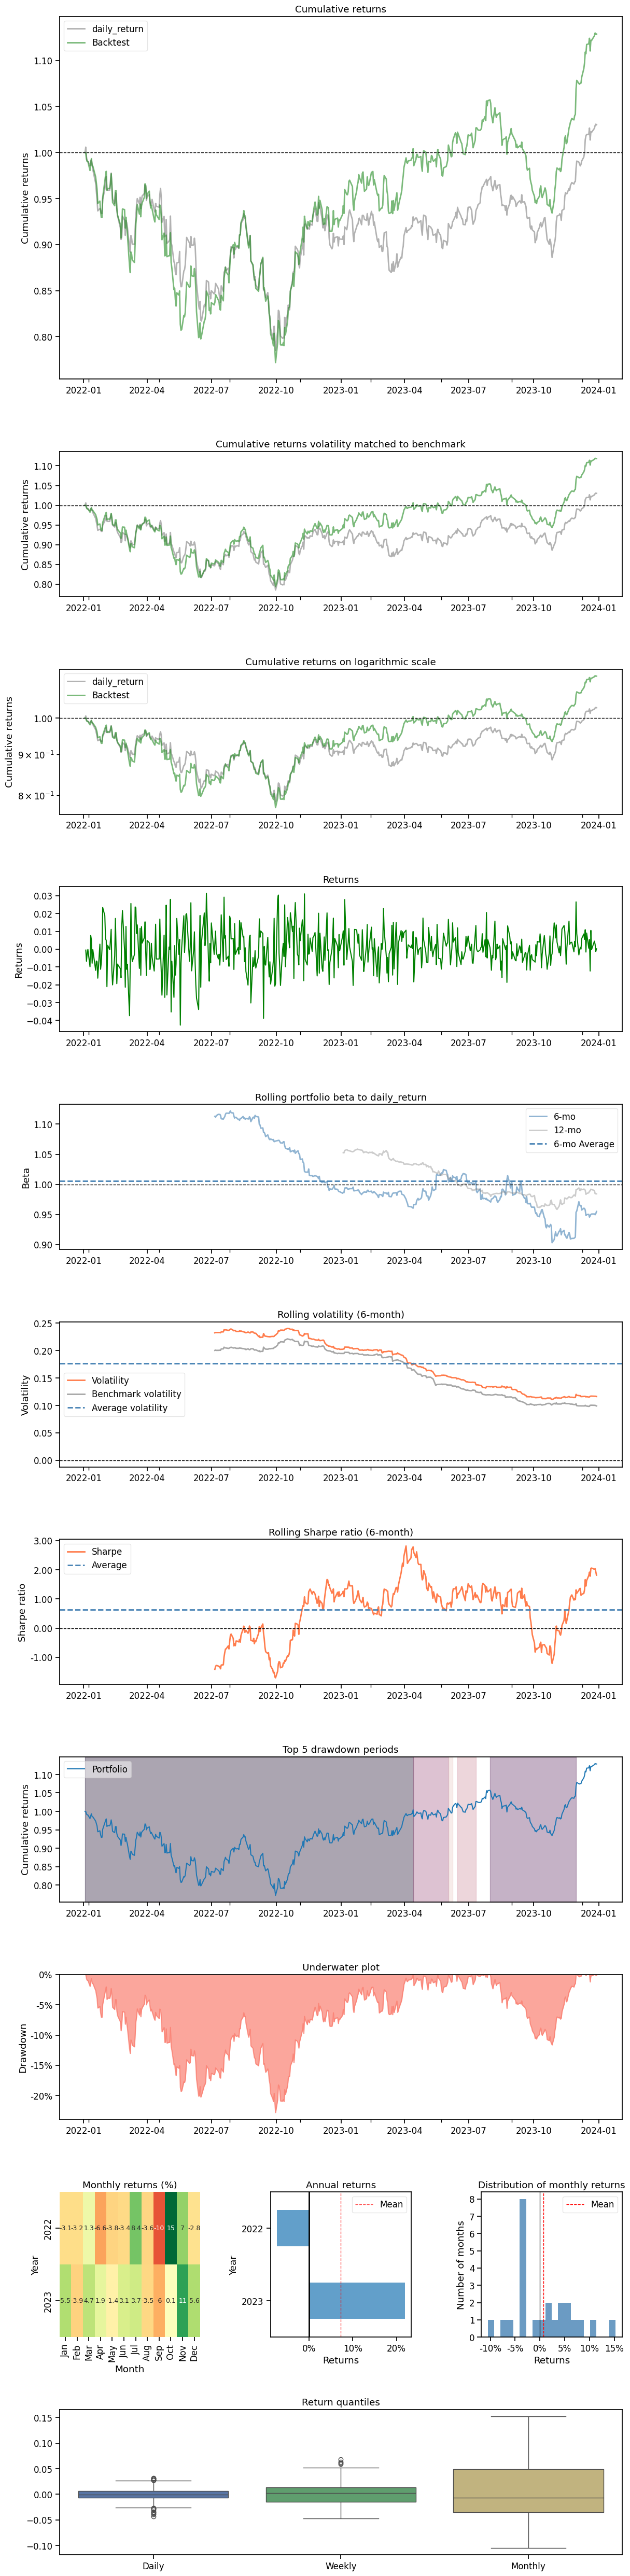

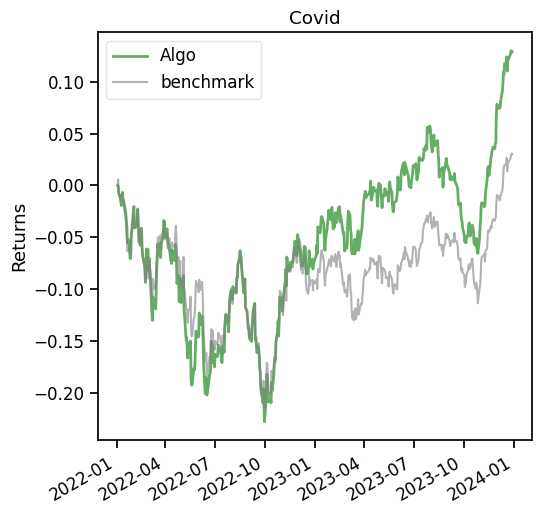

In [15]:
%matplotlib inline
print("==============Compare to DJIA===========")

# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX

if if_using_a2c:
    backtest_plot(df_account_value_a2c,
                    baseline_ticker='^DJI',
                    baseline_start=TRADE_START_DATE,
                    baseline_end=TRADE_END_DATE)
    plt.show()

[*********************100%%**********************]  1 of 1 completed

-----------DOWNLOADING-----------
From = 2022-01-01 to 2024-01-01.
Shape of DataFrame:  (501, 8)


Start date,2022-01-03
End date,2023-12-29
Total months,23
,Backtest
Annual return,3.562%
Cumulative returns,7.207%
Annual volatility,17.445%
Sharpe ratio,0.29
Calmar ratio,0.15
Stability,0.26
Max drawdown,-23.671%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,23.67,2022-01-04,2022-09-30,2023-11-30,498
1,1.19,2023-12-19,2023-12-20,2023-12-26,6
2,0.68,2023-12-01,2023-12-06,2023-12-11,7
3,0.06,2023-12-28,2023-12-29,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


Stress Events,mean,min,max
Covid,0.02%,-4.42%,4.56%


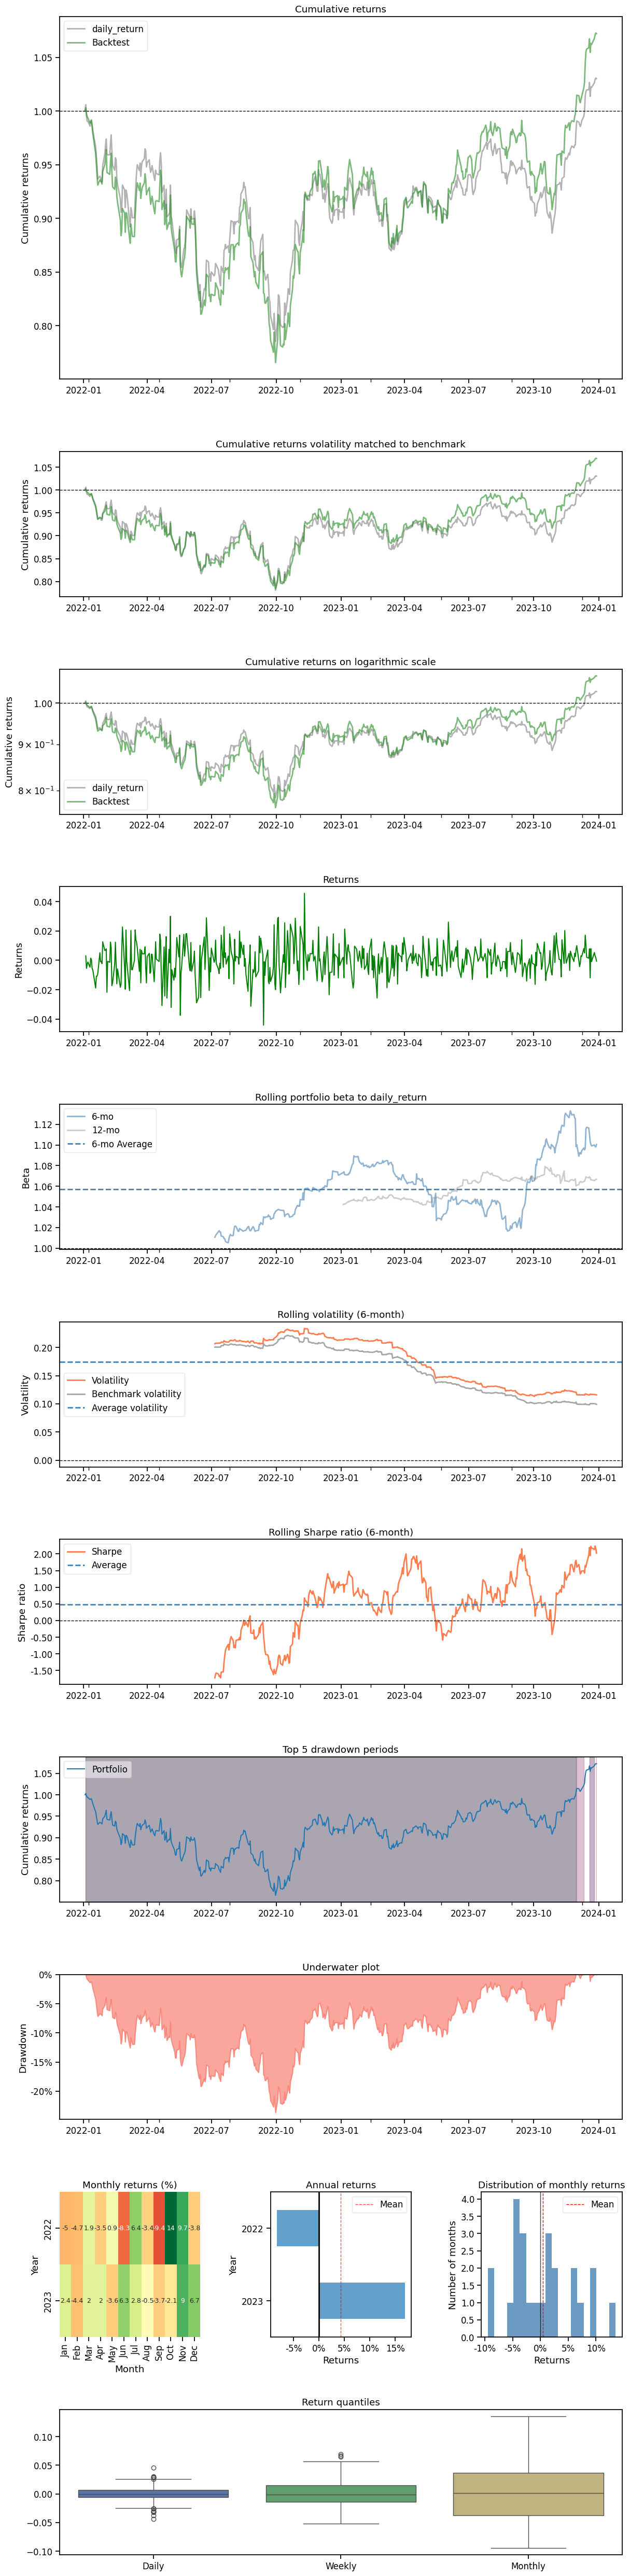

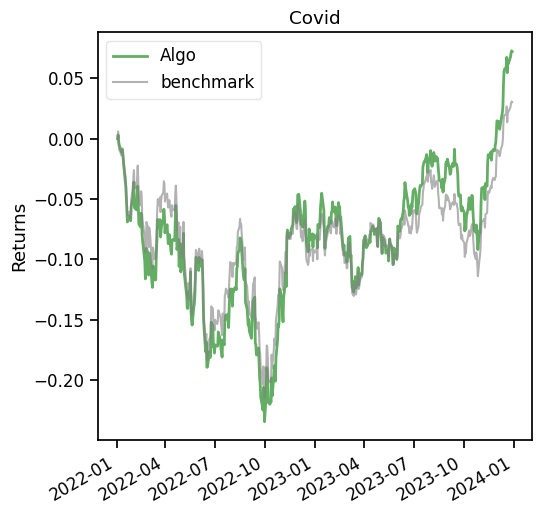

In [16]:
if if_using_ddpg:
    backtest_plot(df_account_value_ddpg,
                    baseline_ticker='^DJI',
                    baseline_start=TRADE_START_DATE,
                    baseline_end=TRADE_END_DATE)
    plt.show()

[*********************100%%**********************]  1 of 1 completed

-----------DOWNLOADING-----------
From = 2022-01-01 to 2024-01-01.
Shape of DataFrame:  (501, 8)


Start date,2022-01-03
End date,2023-12-29
Total months,23
,Backtest
Annual return,6.721%
Cumulative returns,13.806%
Annual volatility,19.502%
Sharpe ratio,0.43
Calmar ratio,0.30
Stability,0.36
Max drawdown,-22.308%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,22.31,2022-02-09,2022-09-30,2023-01-06,238
1,11.10,2023-08-07,2023-09-28,2023-11-29,83
2,6.71,2023-04-13,2023-05-25,2023-07-26,75
3,6.29,2023-02-01,2023-03-13,2023-04-13,52
4,4.40,2023-12-19,2023-12-22,NaT,NaN


Stress Events,mean,min,max
Covid,0.03%,-4.75%,5.39%


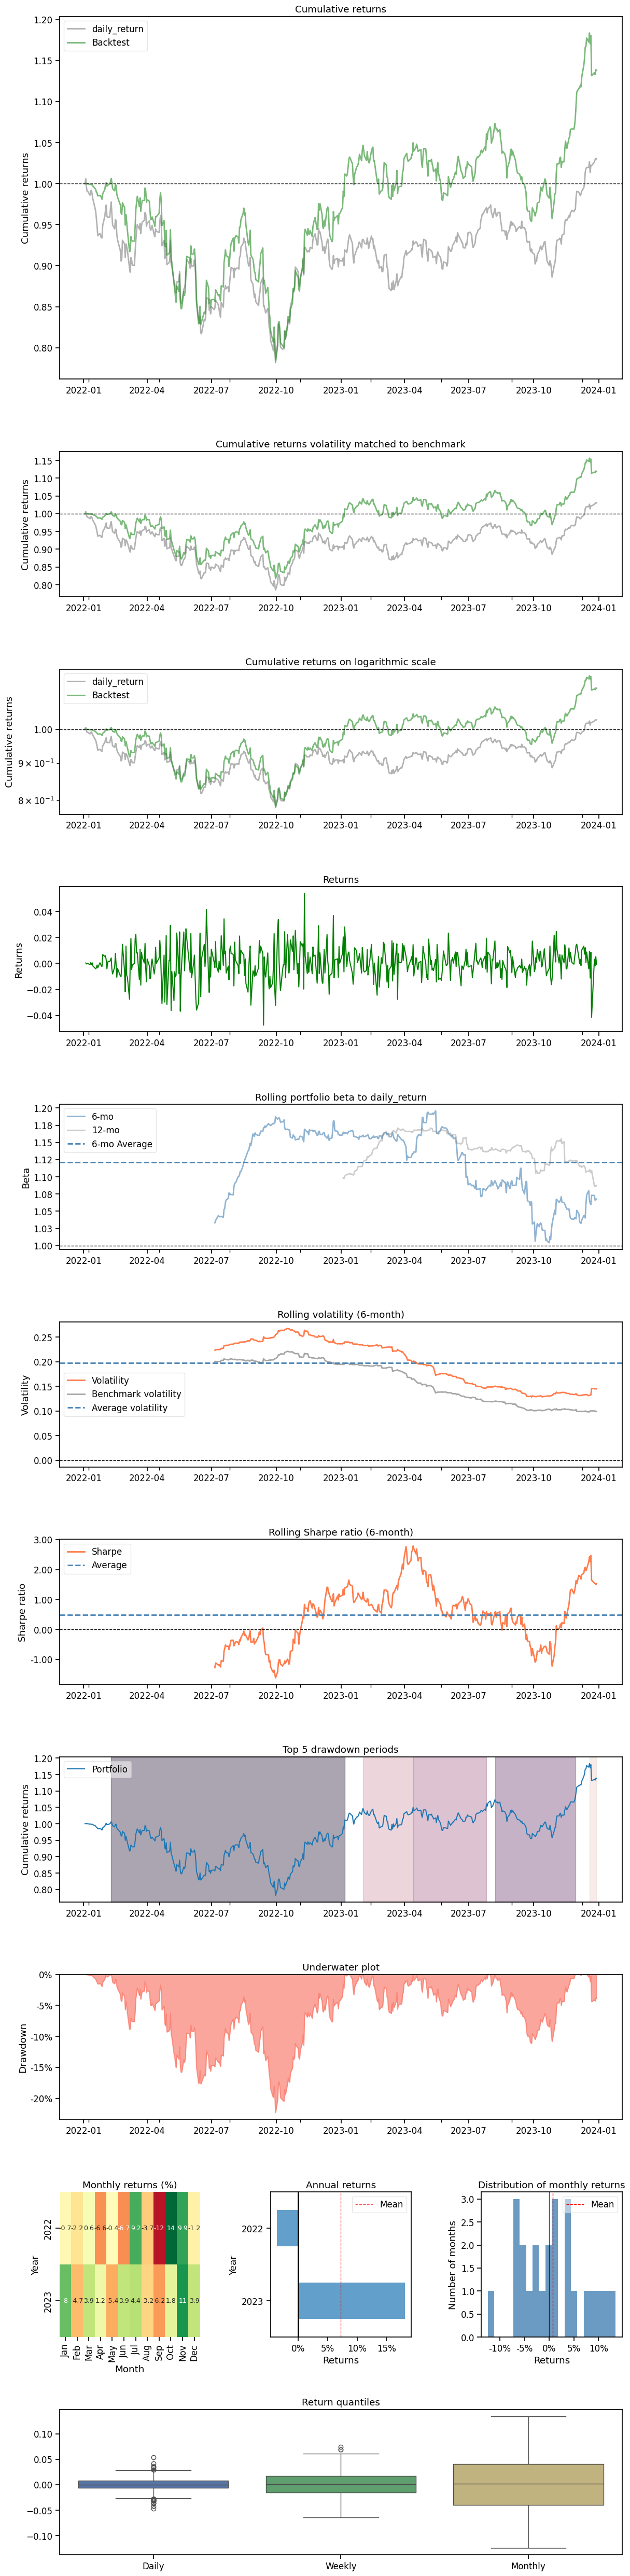

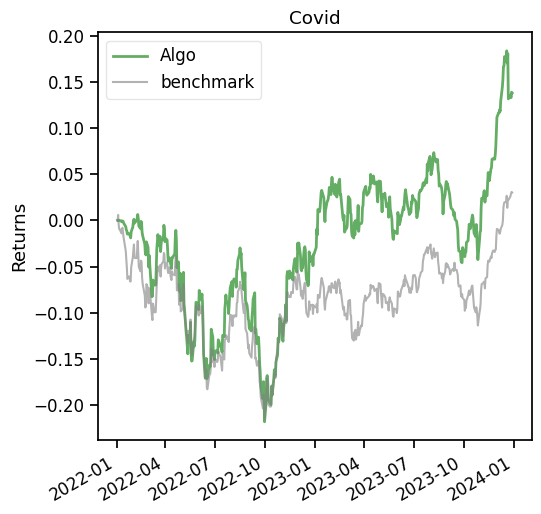

In [17]:

if if_using_ppo:
    backtest_plot(df_account_value_ppo,
                    baseline_ticker='^DJI',
                    baseline_start=TRADE_START_DATE,
                    baseline_end=TRADE_END_DATE)
    plt.show()


## DJIA Index

In [18]:
print("\n==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = TRADE_START_DATE,
        end = TRADE_END_DATE)

stats = backtest_stats(df_dji_, value_col_name = 'close')

df_dji = pd.DataFrame()
df_dji['date'] = df_account_value_a2c['date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
df_dji.to_csv("df_dji+.csv")

[*********************100%%**********************]  1 of 1 completed


==============Get Baseline Stats===========
-----------DOWNLOADING-----------
From = 2022-01-01 to 2024-01-01.
Shape of DataFrame:  (501, 8)
Annual return          0.015073
Cumulative returns     0.030189
Annual volatility      0.161864
Sharpe ratio           0.173449
Calmar ratio           0.068698
Stability              0.099476
Max drawdown          -0.219408
Omega ratio            1.029766
Sortino ratio          0.245550
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.012024
Daily value at risk   -0.020281
dtype: float64


## Mean Variance Optimization
Mean Variance optimization is a very classic strategy in portfolio management. Here, we go through the whole process to do the mean variance optimization and add it as a baseline to compare.

First, process dataframe to the form for MVO weight calculation.

In [19]:
def process_df_for_mvo(df):
  df = df.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
  fst = df
  fst = fst.iloc[0:stock_dimension, :]
  tic = fst['tic'].tolist()

  mvo = pd.DataFrame()

  for k in range(len(tic)):
    mvo[tic[k]] = 0

  for i in range(df.shape[0]//stock_dimension):
    n = df
    n = n.iloc[i * stock_dimension:(i+1) * stock_dimension, :]
    date = n['date'][i*stock_dimension]
    mvo.loc[date] = n['close'].tolist()

  return mvo

In [20]:
# Codes in this section partially refer to Dr G A Vijayalakshmi Pai

# https://www.kaggle.com/code/vijipai/lesson-5-mean-variance-optimization-of-portfolios/notebook

def StockReturnsComputing(StockPrice, Rows, Columns):
  StockReturn = np.zeros([Rows-1, Columns])
  for j in range(Columns):        # j: Assets
    for i in range(Rows-1):     # i: Daily Prices
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100

  return StockReturn

In [21]:
train_mvo = data_split(processed_data, TRAIN_START_DATE,TRAIN_END_DATE).reset_index()
trade_mvo = data_split(processed_data, TRADE_START_DATE,TRADE_END_DATE).reset_index()

In [22]:
StockData = process_df_for_mvo(train_mvo)
TradeData = process_df_for_mvo(trade_mvo)

TradeData.to_numpy()

array([[179.72453308, 210.74034119, 162.60533142, ...,  44.82258606,
         46.13647842,  46.59857178],
       [177.443573  , 211.80941772, 167.82540894, ...,  45.70297241,
         46.50167465,  45.74488831],
       [172.72357178, 209.2993927 , 166.03703308, ...,  46.17307663,
         46.9538269 ,  46.36340332],
       ...,
       [192.90383911, 284.3074646 , 185.88169861, ...,  36.10656357,
         25.97898102,  52.44804001],
       [193.33329773, 286.22247314, 186.61705017, ...,  36.2807579 ,
         25.93997574,  52.34505844],
       [192.28463745, 285.78588867, 186.15992737, ...,  36.48398209,
         25.46213341,  52.37163162]])

In [23]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)

#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [ 0.127  0.083  0.06   0.045  0.016  0.106  0.066  0.013  0.066 -0.002
  0.048  0.051  0.     0.077  0.028  0.07   0.057  0.042 -0.031  0.115
  0.139  0.11   0.083  0.023  0.074  0.111  0.051 -0.022  0.054]
Variance-Covariance matrix of returns
 [[3.007 0.936 1.18  1.423 1.695 1.86  1.656 0.933 0.981 1.432 1.059 1.027
  1.177 1.813 0.635 1.104 0.345 0.448 1.274 0.649 1.768 1.212 0.433 0.695
  0.974 1.523 0.217 1.014 0.559]
 [0.936 1.987 0.763 0.731 1.111 1.078 0.994 0.658 0.729 0.806 0.667 0.742
  0.796 1.028 0.713 0.748 0.436 0.442 0.918 0.929 1.013 0.771 0.43  0.613
  0.803 0.862 0.446 0.878 0.537]
 [1.18  0.763 1.74  1.121 1.381 1.269 1.19  0.86  0.807 1.318 0.93  0.966
  0.935 1.096 0.665 1.186 0.458 0.498 1.065 0.607 1.316 0.993 0.508 0.82
  0.848 1.214 0.43  0.889 0.6  ]
 [1.423 0.731 1.121 3.616 1.98  1.578 1.354 1.024 0.755 1.297 1.061 1.13
  0.999 1.398 0.777 1.118 0.35  0.389 1.251 0.53  1.443 1.163 0.416 0.728
  0.883 1.259 0.335 0.90

In [24]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(29)])
mvo_weights

array([ 75180.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0., 406620., 250030.,
        71100., 197080.,      0.,      0.,      0.,      0.,      0.,
            0.])

In [25]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([1052.504,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   , 5381.167, 1648.348,  736.294, 1764.133,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ])

In [26]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
MVO_result

,Mean Var
2022-01-03,1.502674e+06
2022-01-04,1.493874e+06
2022-01-05,1.476139e+06
2022-01-06,1.465663e+06
2022-01-07,1.470409e+06
...,...
2023-12-22,1.724286e+06
2023-12-26,1.724602e+06
2023-12-27,1.725156e+06
2023-12-28,1.732458e+06


## Ensemble Strategy

In [27]:
unique_trade_date = processed_data[(processed_data.date > TRADE_START_DATE) & (processed_data.date <= TRADE_END_DATE)].date.unique()

In [28]:
rebalance_window = 63
validation_window = 63

df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = pd.concat([df_account_value, temp], ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))
df_account_value.to_csv('df_account_value.csv')

Sharpe Ratio:  0.444954253964277


[*********************100%%**********************]  1 of 1 completed

-----------DOWNLOADING-----------
From = 2022-01-01 to 2024-01-01.
Shape of DataFrame:  (501, 8)


Start date,2022-04-04
End date,2023-10-04
Total months,18
,Backtest
Annual return,6.378%
Cumulative returns,9.718%
Annual volatility,17.284%
Sharpe ratio,0.44
Calmar ratio,0.44
Stability,0.70
Max drawdown,-14.396%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,14.40,2022-04-20,2022-09-30,2022-11-08,145
1,7.70,2023-02-13,2023-03-17,2023-04-11,42
2,6.69,2022-11-30,2023-01-05,2023-01-27,43
3,6.32,2023-04-13,2023-05-25,2023-07-18,69
4,3.78,2023-08-01,2023-08-24,NaT,NaN


Stress Events,mean,min,max
Covid,0.03%,-3.73%,3.86%


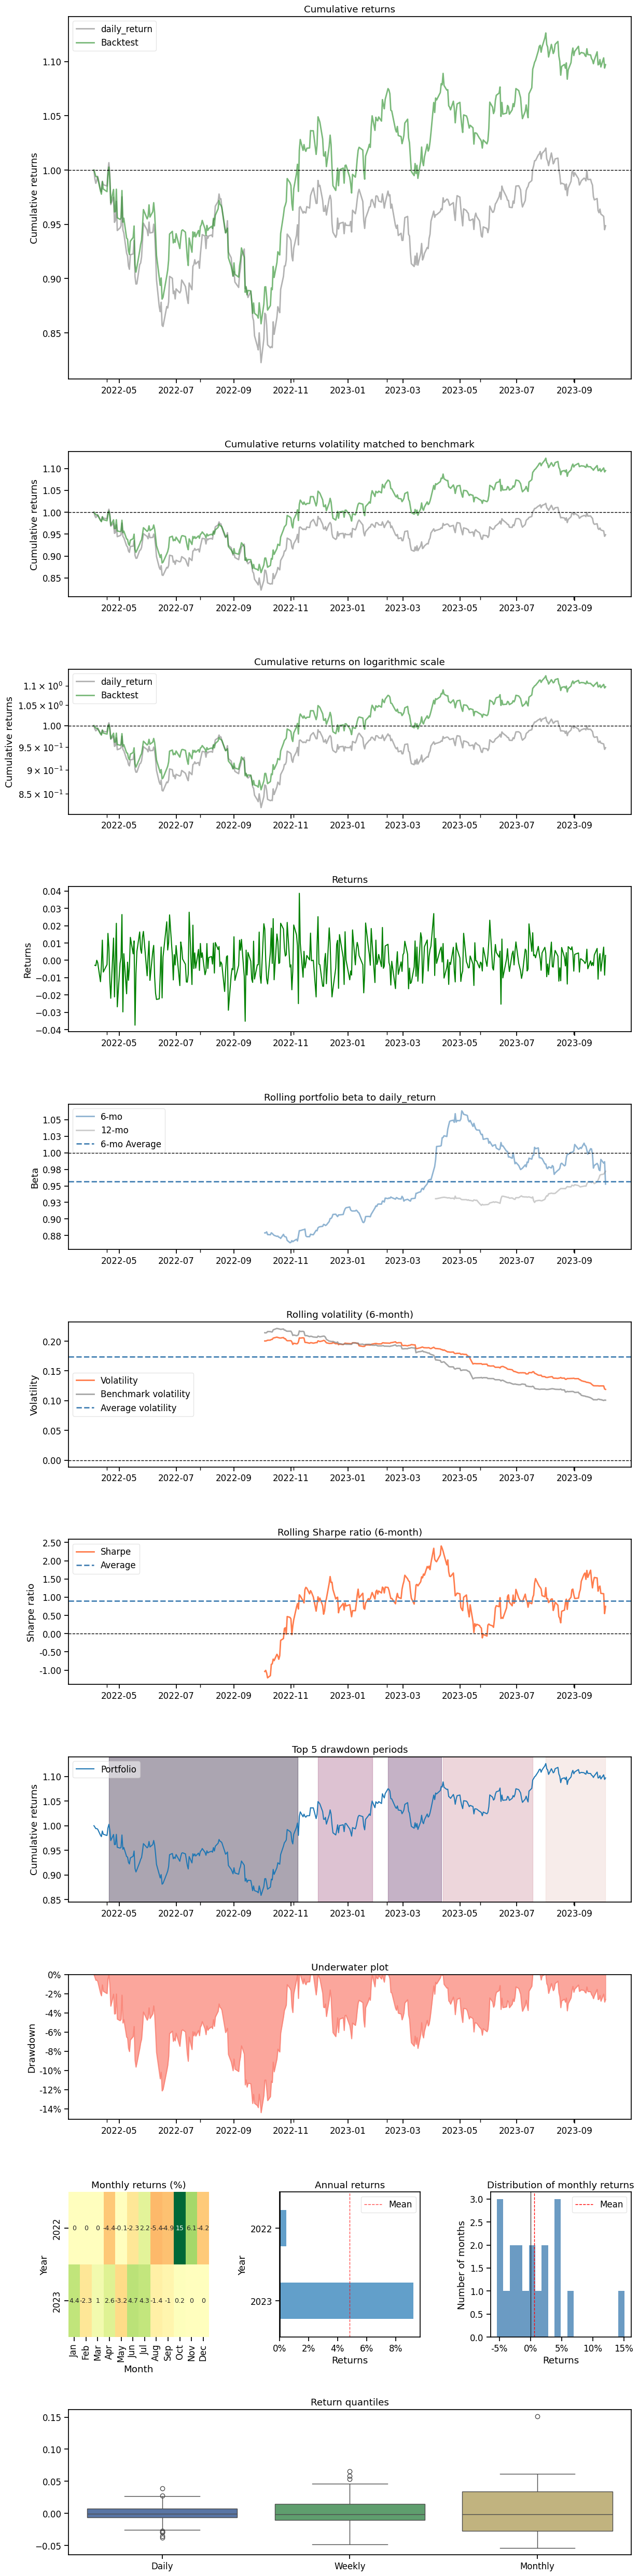

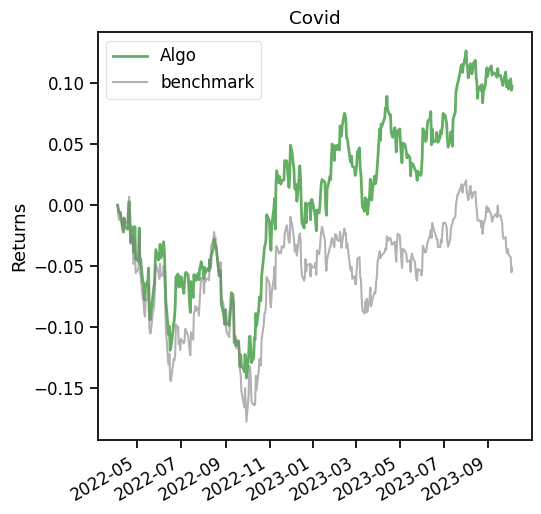

In [29]:
if if_using_ensemble:
    backtest_plot(df_account_value,
                    baseline_ticker='^DJI',
                    baseline_start=TRADE_START_DATE,
                    baseline_end=TRADE_END_DATE)
    plt.show()

In [36]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
df_result_a2c.rename(columns = {'account_value':'a2c'}, inplace = True)
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
df_result_ddpg.rename(columns = {'account_value':'ddpg'}, inplace = True)
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
df_result_ppo.rename(columns = {'account_value':'ppo'}, inplace = True)
df_result_ensemble = pd.DataFrame({'date': df_account_value['datadate'], 'ensemble': df_account_value['account_value']})
df_result_ensemble = df_result_ensemble.set_index('date')

df_account_value_a2c.to_csv("df_account_value_a2c.csv")
df_account_value_ddpg.to_csv("df_account_value_ddpg.csv")
df_account_value_ppo.to_csv("df_account_value_ppo.csv")
df_result_ensemble.to_csv("df_result_ensemble.csv")

#baseline stats
result = pd.DataFrame()
result = pd.merge(result, df_result_a2c, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_ddpg, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True)
result = pd.merge(result, MVO_result, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_dji, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_ensemble, left_index=True, right_index=True)

result.columns = ['a2c', 'ddpg', 'ppo', 'mean var', 'dji', 'ensemble']
print(result.head())

# print("result: ", result)
result.to_csv("result.csv")

                      a2c           ddpg            ppo      mean var  \
date                                                                    
2022-04-04  958069.144411  928689.145666  978689.783316  1.470507e+06   
2022-04-05  947126.787172  920460.524435  967100.985931  1.460971e+06   
2022-04-06  939765.985403  913017.361204  956094.565496  1.446367e+06   
2022-04-07  942837.959299  916750.557356  956042.476461  1.463079e+06   
2022-04-08  938683.493410  920536.155645  959298.409980  1.459456e+06   

                      dji        ensemble  
date                                       
2022-04-04  954539.373410  1000000.000000  
2022-04-05  946866.863661   997164.956353  
2022-04-06  942912.572638   994093.348979  
2022-04-07  945292.194186   994151.878768  
2022-04-08  949051.947116   992940.900220  


<Figure size 1500x500 with 0 Axes>

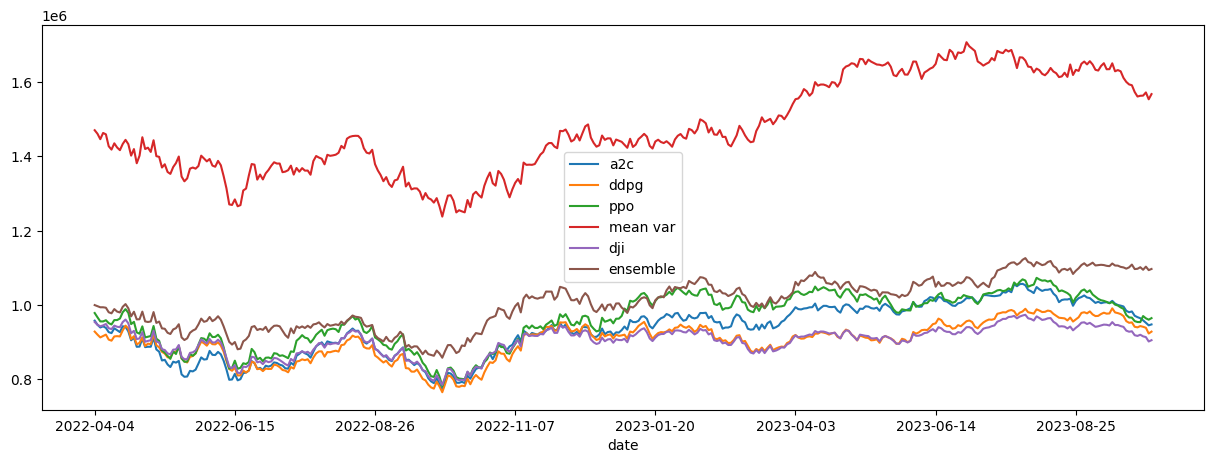

In [37]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();